In [12]:
import os
os.getcwd()

'/data/at677/fewshotlocal'

In [13]:
import torch
from torch.nn import NLLLoss
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn
import math

%matplotlib inline
import pylab as pl
from IPython import display
import time

from helpful_files.networks import PROTO, avgpool, covapool, pL, pCL, fsL, fsCL, fbpredict
from helpful_files.testing import *

In [14]:
# Set Important Values

# General settings
datapath = '/data/dww78/mini_inat_shrunk/'   # The location of your train, test, repr, and query folders. Make sure it ends in '/'!
model = 'myModel-110-new.pth'  # What model do you wish to evaluate, and where is it saved?
gpu = 0                             # What gpu do you wish to run on?
workers = 1                         # Number of cpu worker processes to use for data loading
verbosity = 10                      # How many categories in between status updates 
ensemble = 4                        # How many models to evaluate in parallel
k = 5                               # Evaluate top-k accuracy. Typically 1 or 5. 
torch.cuda.set_device(gpu) 
cudnn.benchmark = True

# Model characteristics
covariance_pooling = False           # Did your model use covariance pooling?
localizing = False                   # Did your model use localization?
fewshot_local = False                # If you used localization: few-shot, or parametric? Few-shot if True, param if False
network_width = 512                  # Number of channels at every layer of the network

# Batch construction
bsize = 64                          # Batch size
boxes_available = 10                # Percentage of images with bounding boxes available (few-shot localization models only)
include_masks = (localizing         # Include or ignore the bounding box annotations?
                 and fewshot_local)
n_trials = (10                      # Number of trials (few-shot localization models only)
            if include_masks else 1)


# Calculate embedding size based on model setup
d = (network_width if not 
     covariance_pooling else
     network_width**2)
if localizing and not covariance_pooling:
    d = network_width*2
assert n_trials == 1 or include_masks, ("Repeated trials will yield repeated identical results under this configuration."+
                                        "Please set ntrials to 1 or use a few-shot localizer.")

In [15]:
# Load Testing Data

d_boxes = torch.load('/data/db638/fewshotlocal/helpful_files/box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

repr_dataset = datasets.ImageFolder(
    datapath+'repr', 
    loader = lambda x: load_transform(x, d_boxes, transform, include_masks))
query_dataset = datasets.ImageFolder(
    datapath+'query',
    loader = lambda x: load_transform(x, d_boxes, transform, include_masks))
repr_loader = torch.utils.data.DataLoader(
    repr_dataset, 
    batch_sampler = OrderedSampler(repr_dataset, bsize),
    num_workers = workers,
    pin_memory = True)
query_loader = torch.utils.data.DataLoader(
    query_dataset,
    batch_sampler = OrderedSampler(query_dataset, bsize),
    num_workers = workers,
    pin_memory = True)
way = len(repr_dataset.classes)

# Determine number of images with bounding boxes per-class
catsizes = torch.LongTensor(np.array([t[1] for t in repr_dataset.imgs])).bincount().float()
ngiv = (catsizes*boxes_available//100)
for i in range(ngiv.size(0)):
    if ngiv[i] == 0:
        ngiv[i] = 1
ngiv = ngiv.long().tolist()

print('Data loaded!')

Data loaded!


In [16]:
new_d_boxes = dict()
for key, value in d_boxes.items():
    new_key = "/data/dww78/mini_inat_shrunk/"+key[3:]
    new_d_boxes[new_key] = value

d_boxes = new_d_boxes

In [17]:
print(list(d_boxes.keys())[0])

/data/dww78/mini_inat_shrunk/train/3171/4c72b1a7b6a86b8de95425db8cd03384.bmp


In [18]:
import torch.nn as nn
import torch
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)

        self.relu = nn.ReLU()

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = conv3x3(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)
      
        self.conv4 = conv3x3(inplanes, planes)
        self.bn4 = nn.BatchNorm2d(planes)

        self.maxpool = nn.MaxPool2d(stride)

        self.downsample = downsample
        self.stride = stride
        self.num_batches_tracked = 0

    def forward(self, x):
        self.num_batches_tracked += 1

        residual = x
        residual = self.conv4(residual)
        residual = self.bn4(residual)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += residual
        out = self.relu(out)
        out = self.maxpool(out)
        
        return out


class ResNet(nn.Module):

    def __init__(self, block):
        self.inplanes = 3
        super(ResNet, self).__init__()
        self.layer1 = BasicBlock(3,64, 2)
        self.layer2 = BasicBlock(64,128, 2)
        self.layer3 = BasicBlock(128,256, 2)
        self.layer4 = BasicBlock(256,512, 1)
#         UNCOMMENT ONLY FOR COVARIANCE POOLING
#         self.layer5 = nn.Conv2d(512, 128, kernel_size=1, stride=1)


        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # TODO: is this fine?
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    
    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
#         UNCOMMENT ONLY FOR COVARIANCE POOLING
#         x = self.layer5(x)
        return x/math.sqrt(network_width)


def resnet12():
    """Constructs a ResNet-12 model.
    """
    model = ResNet(BasicBlock)
    return model

In [19]:
# Make Models
    
# models = [PROTO(network_width).cuda() for i in range(ensemble)]
models = [resnet12().cuda() for i in range(ensemble)]

expander = avgpool()
if localizing:
    if fewshot_local:
        expander = fsCL if covariance_pooling else fsL
    else:
        expander = pCL() if covariance_pooling else pL()
elif covariance_pooling:
    expander = covapool
expanders = [expander for _ in range(ensemble)]

# Load saved parameters
model_state = torch.load(model)
for i in range(ensemble):
    models[i].load_state_dict(model_state[i])
    models[i].eval()
    # Zero out the bias on the final layer, since it doesn't do anything
    # models[i].process[-1].layers[-1].bias.data.zero_()

# Load additional parameters for parametric localizer models
if localizing and not fewshot_local:
    fbcentroids = torch.load(model[:model.rfind('.')]+'_localizers'+model[model.rfind('.'):])
    for i in range(ensemble):
        expanders[i].centroids.data = fbcentroids[i]
        expanders[i].cuda()

print("Ready to go!")

Ready to go!


In [20]:
#                                                    EVALUATE

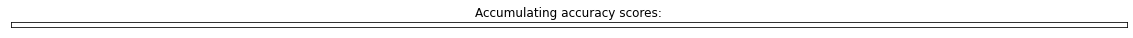

Accuracies and 95% confidence intervals
Mean accuracy: 		62.54 	+/- 0.11
Per-class accuracy: 	61 	+/- 0.14


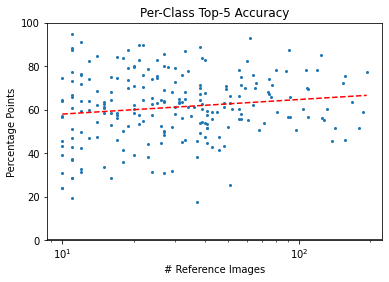

In [21]:
acclist = []
pcacclist = []
alldispacc = np.zeros(way)
for r in range(n_trials):
    # Accumulate foreground/background prototypes, if using
    fbcentroids = (accumulateFB(models, repr_loader, way, network_width, ngiv, bsize)
                   if include_masks else 
                   [None]*ensemble)
    # Accumulate category prototypes
    centroids, counts = accumulate(models, repr_loader, expanders, 
                                   fbcentroids, way, d)
    # Score the models
    allacc, dispacc, perclassacc = score(k, centroids, fbcentroids, models, 
                                         query_loader, expanders, way)
    # Record statistics
    acclist = acclist+allacc
    pcacclist = pcacclist+list(perclassacc)
    alldispacc += dispacc

# Aggregate collected statistics
accs = sum(acclist)/n_trials/ensemble
pcaccs = sum(pcacclist)/n_trials/ensemble
alldispacc = alldispacc/n_trials
confs = 1.96*np.sqrt(np.var(acclist)/n_trials/ensemble)
pcconfs = 1.96*np.sqrt(np.var(pcacclist)/n_trials/ensemble)

# Report
print("Accuracies and 95% confidence intervals")
print("Mean accuracy: \t\t%.2f \t+/- %.2f" % (accs*100, confs*100))
print("Per-class accuracy: \t%.f \t+/- %.2f" % (pcaccs*100, pcconfs*100))
logcounts = [np.log10(c) for c in counts]
pl.figure()
pl.axhline(0,color='k')
pl.scatter(counts, dispacc*100, s=4)
z = np.polyfit(logcounts, np.array(dispacc)*100, 1)
p = np.poly1d(z)
pl.plot([min(counts),max(counts)], [p(min(logcounts)),p(max(logcounts))], "r--")
pl.ylim([0,100])
pl.xlabel('# Reference Images')
pl.ylabel('Percentage Points')
pl.xscale('log')
pl.title('Per-Class Top-%d Accuracy' % k)
pl.show()

In [11]:
!file /data/db638/repr/1027/bafc96ec591660f9dd262d54d8ec1d48.bmp

/data/db638/repr/1027/bafc96ec591660f9dd262d54d8ec1d48.bmp: broken symbolic link to ../test/1027/bafc96ec591660f9dd262d54d8ec1d48.bmp


In [22]:
# Free up GPU space
torch.cuda.empty_cache() 

In [ ]:
# Shut down the notebook

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>